In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.metrics import confusion_matrix

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = "/storage/chest_xray/"
sz=300
arch=resnet34 

In [6]:
os.listdir(PATH)

['models', 'val', 'test', '.DS_Store', 'train', 'tmp']

In [7]:
os.listdir(f'{PATH}val')

['NORMAL', 'PNEUMONIA', '.DS_Store']

In [8]:
files = os.listdir(f'{PATH}val/NORMAL')[:5]
files

['NORMAL2-IM-1427-0001.jpeg',
 'NORMAL2-IM-1431-0001.jpeg',
 'NORMAL2-IM-1436-0001.jpeg',
 'NORMAL2-IM-1440-0001.jpeg',
 '.DS_Store']

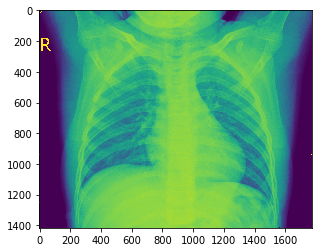

In [9]:
img = plt.imread(f'{PATH}val/NORMAL/{files[0]}')
plt.imshow(img)

In [10]:
img.shape

(1416, 1776)

In [11]:
img[:4,:4]

array([[  3,   0,   4,   1],
       [  6,   5,   2,   0],
       [  0,   1,   3, 255],
       [  3,   0, 255,   6]], dtype=uint8)

## get the Data

In [12]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), val_name='val')

#def get_data(sz, bs):
#    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
#    data = ImageClassifierData.from_paths(PATH, 'train', )

## Have a look at images size

In [13]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [14]:
row_sz, col_sz = list(zip(*size_d.values()))

(array([ 61.,  20.,  76., 251., 701., 676., 735., 668., 606., 478., 390., 256., 133.,  77.,  32.,  22.,  19.,
          9.,   3.,   3.]),
 array([ 384. ,  510.6,  637.2,  763.8,  890.4, 1017. , 1143.6, 1270.2, 1396.8, 1523.4, 1650. , 1776.6,
        1903.2, 2029.8, 2156.4, 2283. , 2409.6, 2536.2, 2662.8, 2789.4, 2916. ]),
 <a list of 20 Patch objects>)

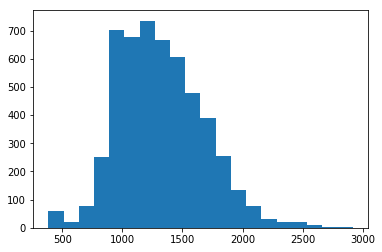

In [15]:
plt.hist(row_sz, bins=20)

## Choosing the learning rate

In [16]:

learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


 72%|███████▏  | 59/82 [00:01<00:00, 39.57it/s, loss=2.33] 


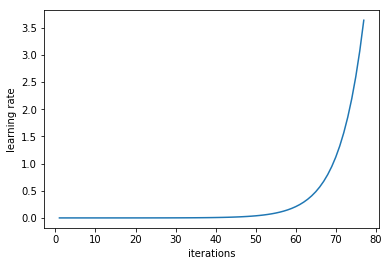

In [17]:
learn.sched.plot_lr()

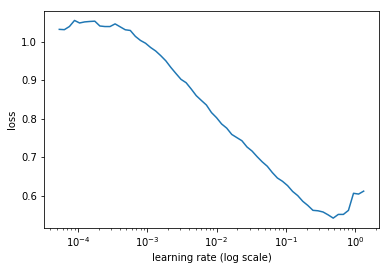

In [18]:
learn.sched.plot()

## Train the model and predict

In [19]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), val_name='val')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.2,4)

epoch      trn_loss   val_loss   accuracy                  
    0      0.554864   0.140828   0.9375    
    1      0.270631   0.016624   1.0                       
    2      0.165625   0.191709   0.9375                    
    3      0.111179   0.164672   0.875                     



[array([0.16467]), 0.875]

validation loss is much bigger than the training loss and it means We have *underfitting*. Add one more cycle:

In [20]:
learn.fit(0.2,4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.07757    0.18754    0.875     
    1      0.074835   0.200976   0.9375                     
    2      0.069877   0.277279   0.875                      
    3      0.076446   0.087924   0.9375                     
    4      0.069994   0.147714   0.875                      
    5      0.050763   0.274338   0.875                      
    6      0.044839   0.274242   0.875                      
    7      0.054362   0.182038   0.875                      
    8      0.06944    0.370589   0.875                      
    9      0.053025   0.18397    0.9375                     
    10     0.043831   0.136157   0.9375                     
    11     0.035038   0.170481   0.9375                     
    12     0.029987   0.288646   0.9375                     
    13     0.023696   0.238683   0.9375                     
    14     0.02132    0.306341   0.9375                     



[array([0.30634]), 0.9375]

## Data augmentation
We still have the problem with the losses, there still high diffrence between validation loss and trainig loss so we need to add some __*data augmentation*__ 

In [22]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, val_name='val', trn_name='train')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.05, 3, cycle_len=1, cycle_mult=3)
learn.save('1024_data_augmentation')

epoch      trn_loss   val_loss   accuracy                  
    0      0.203707   0.227836   0.8125    
    1      0.148845   0.652605   0.625                     
    2      0.109178   0.155438   0.9375                    
    3      0.083029   0.116942   0.9375                     
    4      0.087426   0.127286   0.9375                     
    5      0.092668   0.057632   0.9375                     
    6      0.076079   0.173893   0.875                      
    7      0.072556   0.131256   0.9375                     
    8      0.054524   0.118325   0.9375                     
    9      0.048099   0.053648   0.9375                     
    10     0.041486   0.078976   0.9375                     
    11     0.044527   0.129204   0.9375                     
    12     0.039055   0.127179   0.9375                     



## Unfreeze the layers by precompute=False

In [23]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.save('1024_unfreeze')

epoch      trn_loss   val_loss   accuracy                  
    0      0.150416   0.027565   1.0       
    1      0.146893   0.035574   1.0                       
    2      0.115905   0.037743   1.0                       
    3      0.112864   0.040551   1.0                       
    4      0.122303   0.033454   1.0                       
    5      0.108001   0.031858   1.0                       
    6      0.106207   0.042777   1.0                       



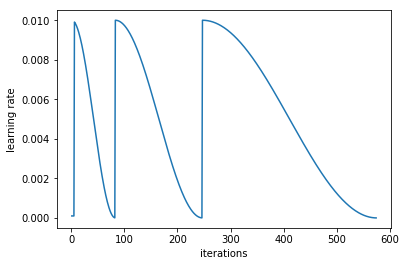

In [24]:
learn.sched.plot_lr()

## TTA (Test time augmentaiton)

In [25]:
log_preds, y= learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.9375

In [26]:
probs.shape

(16, 2)

## Analyze the result

# Confusion Matrix

In [27]:
probs

array([[0.83363, 0.16637],
       [0.63549, 0.36451],
       [0.5726 , 0.4274 ],
       [0.47518, 0.52482],
       [0.71119, 0.28881],
       [0.94957, 0.05043],
       [0.68899, 0.31101],
       [0.52688, 0.47312],
       [0.00008, 0.99992],
       [0.00012, 0.99988],
       [0.00031, 0.99969],
       [0.00046, 0.99954],
       [0.0255 , 0.9745 ],
       [0.00568, 0.99432],
       [0.00017, 0.99983],
       [0.00009, 0.99991]], dtype=float32)

In [28]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1] # prob

[[7 1]
 [0 8]]


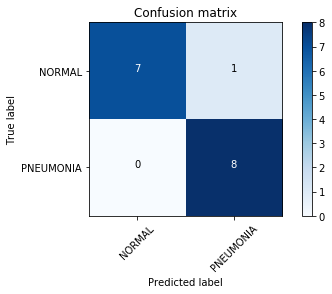

In [30]:
cm = confusion_matrix(y, preds)

plot_confusion_matrix(cm, data.classes)

In [31]:
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [32]:
data.classes

['NORMAL', 'PNEUMONIA']

In [33]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(16, 2)

In [34]:
log_preds

array([[ -0.03674,  -3.32218],
       [ -0.01246,  -4.39131],
       [ -0.06178,  -2.81495],
       [ -0.21611,  -1.63806],
       [ -0.00794,  -4.84031],
       [ -0.03068,  -3.49931],
       [ -0.09486,  -2.4024 ],
       [ -0.18862,  -1.76087],
       [-12.19551,  -0.     ],
       [-11.50326,  -0.00001],
       [-11.94413,  -0.00001],
       [ -8.16258,  -0.00029],
       [ -3.46448,  -0.03179],
       [ -5.76859,  -0.00313],
       [-12.47908,  -0.     ],
       [-11.31638,  -0.00001]], dtype=float32)

In [36]:
# from log probablities to 0 and 1 
preds = np.argmax(log_preds, axis=1)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [39]:
# example of NORMAL probablities
probs = np.exp(log_preds[:,0])
probs

array([0.96393, 0.98762, 0.94009, 0.80564, 0.9921 , 0.96978, 0.9095 , 0.8281 , 0.00001, 0.00001, 0.00001,
       0.00029, 0.03129, 0.00312, 0.     , 0.00001], dtype=float32)

In [40]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y) == is_correct)

In [41]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        

In [42]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


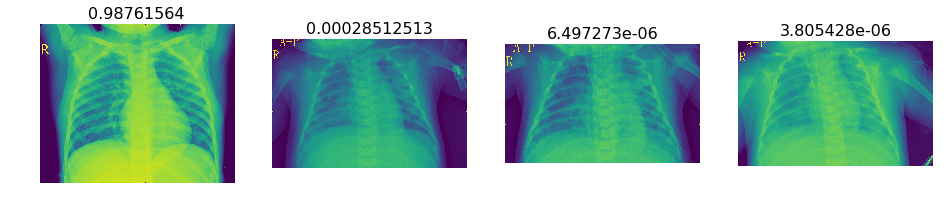

In [43]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [44]:
# 2. A few incorrect lables as random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [45]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct NORMAL


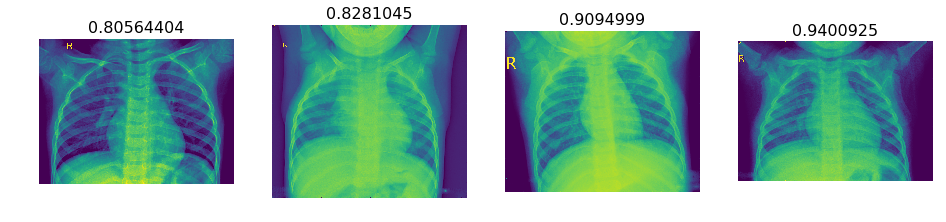

In [46]:
plot_val_with_title(most_by_correct(0, True), "Most correct NORMAL")


Most correct PNEUMONIA


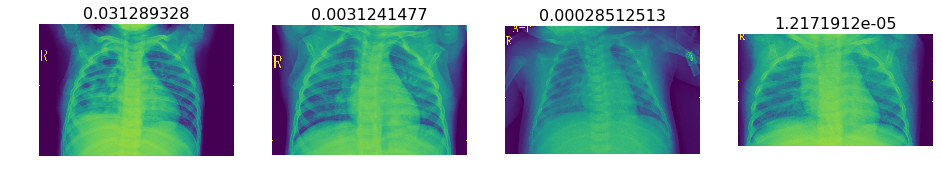

In [47]:
plot_val_with_title(most_by_correct(1, True), "Most correct PNEUMONIA")


In [48]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect NORMAL")

Most incorrect NORMAL


<Figure size 1152x576 with 0 Axes>

In [49]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect PNEUMONIA")

Most incorrect PNEUMONIA


<Figure size 1152x576 with 0 Axes>

Most uncertain predictions


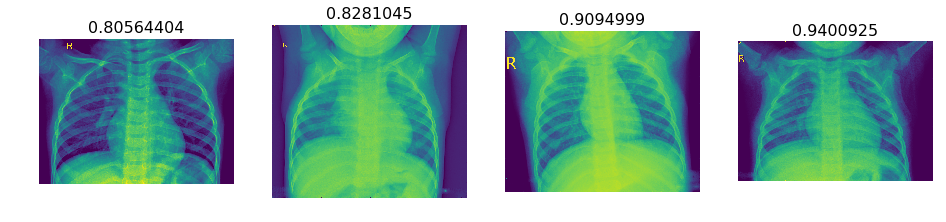

In [50]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")